In [5]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
import kerastuner
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import numpu as np

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Using GPU for computations")
else:
    print("No GPU found, using CPU")

Using GPU for computations


In [26]:
def build_model(hp):
    activation = hp.Choice('activation', values=['relu', 'tanh', 'elu', 'swish']) # Tunable activation function
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
        padding='same',
        activation=activation, # Use the chosen activation
        input_shape=(32, 32, 3),
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
        padding='same',
        activation=activation, # Use the chosen activation
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=128, max_value=512, step=128),
        kernel_size=hp.Choice('conv_3_kernel', values=[3, 5]),
        padding='same',
        activation=activation, # Use the chosen activation
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=512, step=128),
        activation=activation, # Use the chosen activation
        kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='log'))
    ))
    model.add(layers.Dropout(hp.Float('dropout_4', min_value=0.3, max_value=0.6, step=0.1)))

    model.add(layers.Dense(10, activation='softmax')) # Output layer uses softmax

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()

# Split Training Data into Train and Validation Sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [28]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Adjust as needed
    executions_per_trial=1, # Adjust as needed
    directory='cifar10_tuning',  # Directory to save tuning results
    project_name='cnn_cifar10'
)

In [29]:
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Trial 10 Complete [00h 03m 41s]
val_accuracy: 0.5580000281333923

Best val_accuracy So Far: 0.7702999711036682
Total elapsed time: 00h 31m 04s


In [37]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\nThe best hyperparameters are:")
print(f"Filters (Layer 1): {best_hps.get('conv_1_filter')}")
print(f"Filters (Layer 2): {best_hps.get('conv_2_filter')}")
print(f"Filters (Layer 3): {best_hps.get('conv_3_filter')}")
print(f"Kernel (Layer 1): {best_hps.get('conv_1_kernel')}")
print(f"Kernel (Layer 2): {best_hps.get('conv_2_kernel')}")
print(f"Kernel (Layer 3): {best_hps.get('conv_3_kernel')}")
print(f"L2 Reg: {best_hps.get('l2_reg')}")
print(f"Dropout 1: {best_hps.get('dropout_1')}")
print(f"Dropout 2: {best_hps.get('dropout_2')}")
print(f"Dropout 3: {best_hps.get('dropout_3')}")
print(f"Dropout 4: {best_hps.get('dropout_4')}")
print(f"Dense Units: {best_hps.get('dense_1_units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")



The best hyperparameters are:
Filters (Layer 1): 128
Filters (Layer 2): 128
Filters (Layer 3): 256
Kernel (Layer 1): 3
Kernel (Layer 2): 5
Kernel (Layer 3): 5
L2 Reg: 4.136334652968616e-05
Dropout 1: 0.30000000000000004
Dropout 2: 0.4
Dropout 3: 0.30000000000000004
Dropout 4: 0.5
Dense Units: 384
Learning Rate: 0.0002462736426890864


In [38]:
best_model = tuner.hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       409728    
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 128)     

In [39]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

In [40]:
history = best_model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val), callbacks=[stop_early])

Epoch 1/50
1250/1250 [==============================] - 21s 17ms/step - loss: 1.8290 - accuracy: 0.3710 - val_loss: 1.6621 - val_accuracy: 0.4908
Epoch 2/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4224 - accuracy: 0.5084 - val_loss: 1.1911 - val_accuracy: 0.6026
Epoch 3/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.2502 - accuracy: 0.5746 - val_loss: 1.0881 - val_accuracy: 0.6395
Epoch 4/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1199 - accuracy: 0.6245 - val_loss: 0.9948 - val_accuracy: 0.6630
Epoch 5/50
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0184 - accuracy: 0.6615 - val_loss: 0.8482 - val_accuracy: 0.7160
Epoch 6/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.9476 - accuracy: 0.6891 - val_loss: 1.1412 - val_accuracy: 0.6510
Epoch 7/50
1250/1250 [==============================] - 20s 16ms/step - loss: 0.8846 - accuracy: 0.7127 - val_loss: 0.8560 -

In [41]:
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.9324
Test Accuracy: 0.8120


In [44]:
with tf.device('/GPU:0'):
    y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_test, y_pred_classes, target_names=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
print(f"\nClassification Report:\n{report}")

313/313 [==============================] - 2s 5ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.83      0.87      0.85      1000
  automobile       0.90      0.91      0.90      1000
        bird       0.76      0.71      0.74      1000
         cat       0.72      0.57      0.64      1000
        deer       0.82      0.78      0.80      1000
         dog       0.65      0.80      0.72      1000
        frog       0.85      0.86      0.86      1000
       horse       0.88      0.84      0.86      1000
        ship       0.83      0.94      0.88      1000
       truck       0.92      0.84      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



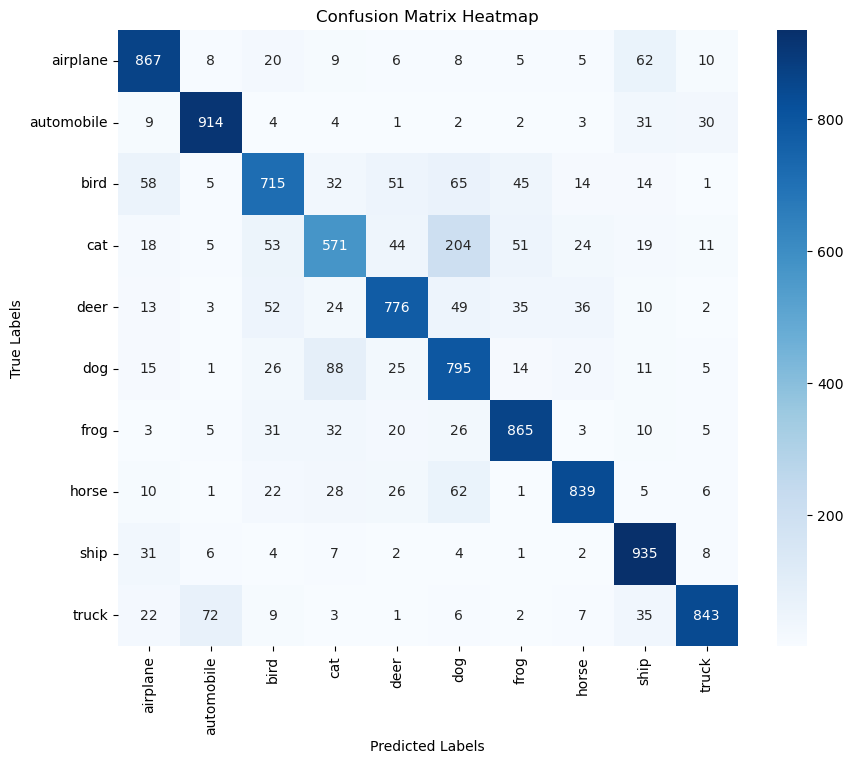

In [46]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
], yticklabels=[
    "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"
])
plt.title("Confusion Matrix Heatmap")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [47]:
best_model.save('models/savemodel/hyp_tuned_model')

INFO:tensorflow:Assets written to: ./hyp_tuned_model\assets


INFO:tensorflow:Assets written to: ./hyp_tuned_model\assets


In [6]:
hyper_tuned_model = load_model('models/savemodel/hyp_tuned_model')

In [8]:
hyper_tuned_model.save('models/keras/hyper_tuned_model.keras')